In [1]:
%matplotlib inline
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from hyperopt import STATUS_OK, fmin, hp, tpe

In [2]:
application_df = pd.read_csv('../data/org/application_train.csv')

In [3]:
categorical_cols = []

for col in application_df.columns:
    if application_df[col].dtypes == object:
        categorical_cols.append(col)
    if application_df[col].dtypes == int or application_df[col].dtypes == float:
        application_df[col] = application_df[col].fillna(application_df[col].mean())

In [4]:
application_df_dummy = pd.get_dummies(application_df, columns=categorical_cols)
application_df_dummy.head()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# feature_importanceを出しながらプロットまでする関数たち

def get_feature_importance(df, target_col, model):
    df_pos = df[df[target_col]==1].iloc[:20000,:]
    df_neg = df[df[target_col]==0].sample(frac=1).iloc[:20000,:]
    
    df_combined = pd.concat([df_pos, df_neg], axis=0)
    df_train, df_eval = train_test_split(df_combined, test_size=0.2, random_state=0)
    train_X, train_y = df_train.iloc[:,2:], df_train.iloc[:,1]
    eval_X, eval_y = df_eval.iloc[:,2:], df_eval.iloc[:,1]

    model.fit(train_X, train_y)
    pred_y = model.predict(eval_X)
    print('AUC: {}'.format(roc_auc_score(eval_y, pred_y)))
    print('Accuracy: {}'.format(accuracy_score(eval_y, pred_y)))
    
    col_names = train_X.columns
    importances = model.feature_importances_    
    plot_feature_importance(col_names, importances)
    
    f_importance_array = np.concatenate([np.array(col_names).reshape(-1,1),importances.reshape(-1,1)], axis=1)
    
    return pd.DataFrame(f_importance_array, columns=['col_name', 'importance'])
    
    
def plot_feature_importance(col_names, importances):
    indices = np.argsort(importances)
    plt.figure(figsize=(10,100))
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), col_names[indices])
    plt.show()

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=20190622)


In [7]:
# 寄与度が高いものの正体のわからないカラムを除く
application_df_dummy_replace = application_df_dummy.drop(columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], axis=1)


AUC: 0.62490424990425
Accuracy: 0.624875


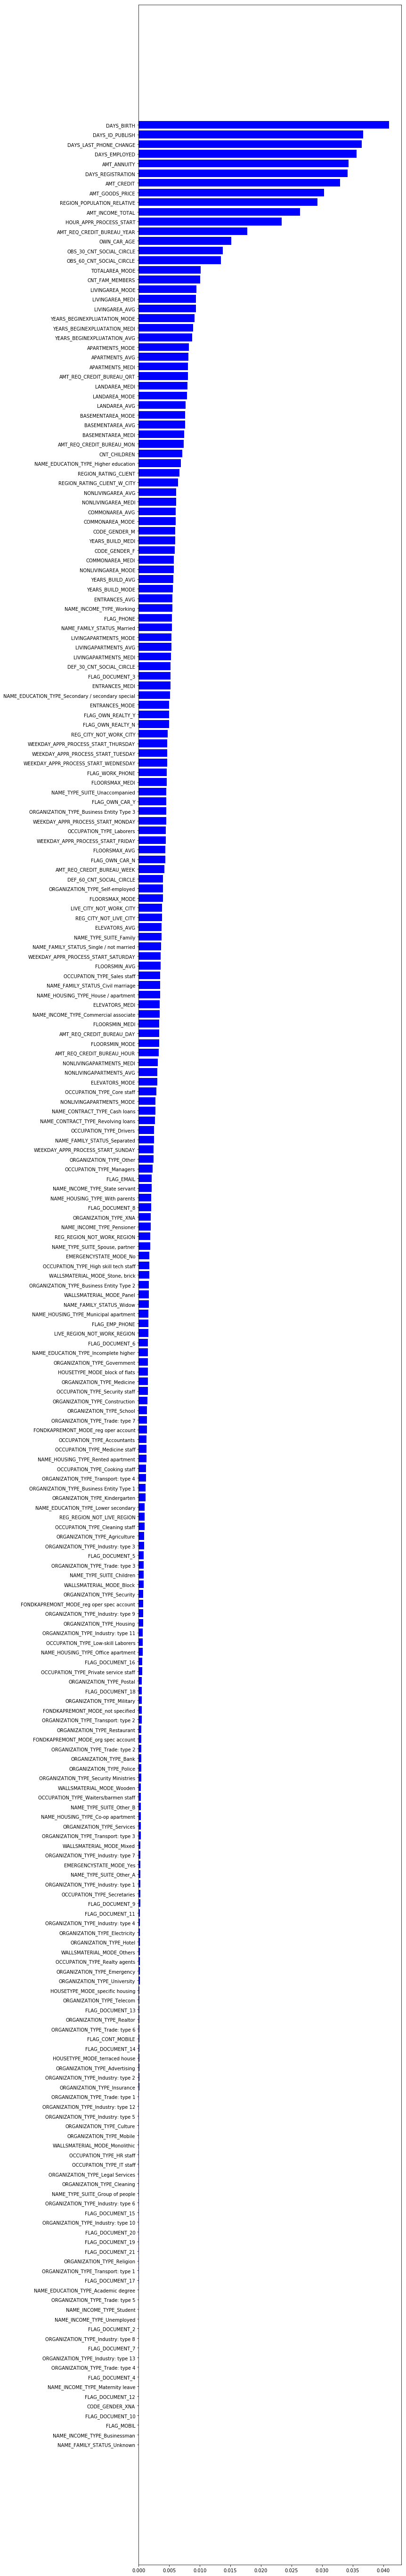

,col_name,importance
6,DAYS_BIRTH,0.040914
9,DAYS_ID_PUBLISH,0.0366825
74,DAYS_LAST_PHONE_CHANGE,0.0364965
7,DAYS_EMPLOYED,0.0356126
3,AMT_ANNUITY,0.0343316
8,DAYS_REGISTRATION,0.0341551
2,AMT_CREDIT,0.032944
4,AMT_GOODS_PRICE,0.0302829
5,REGION_POPULATION_RELATIVE,0.0292214
1,AMT_INCOME_TOTAL,0.0263888


In [8]:
col_importances = get_feature_importance(df=application_df_dummy_replace, target_col='TARGET', model=rf_model)
col_importances.sort_values('importance', ascending=False).iloc[:20,:]


In [39]:
# 使用するカラムをfeature_importancesの上位20個に限定
import pdb
USE_COLUMNS = col_importances.sort_values('importance', ascending=False).iloc[:40,:].col_name.unique()
#pdb.set_trace()
USE_COLUMNS = USE_COLUMNS.tolist()
USE_COLUMNS.append('TARGET')
USE_COLUMNS


['DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'DAYS_REGISTRATION',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'AMT_INCOME_TOTAL',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OWN_CAR_AGE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'TOTALAREA_MODE',
 'CNT_FAM_MEMBERS',
 'LIVINGAREA_MODE',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'APARTMENTS_MODE',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LANDAREA_AVG',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'CNT_CHILDREN',
 'NAME_EDUCATION_TYPE_Higher education',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'TARGET']

In [40]:
experiment_df = application_df_dummy[USE_COLUMNS]

In [41]:
def split_dataset(df, target_col):
    '''
    正例・負例のバランスを整えながら分割する関数
    '''
    df_pos = df[df[target_col]==1].iloc[:20000,:]
    df_neg = df[df[target_col]==0].sample(frac=1).iloc[:20000,:]
    
    df_combined = pd.concat([df_pos, df_neg], axis=0)
    df_train, df_eval = train_test_split(df_combined, test_size=0.2, random_state=0)
    train_X, train_y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
    eval_X, eval_y = df_eval.iloc[:,:-1], df_eval.iloc[:,-1]
    return train_X, eval_X, train_y, eval_y


In [42]:
train_X, eval_X, train_y, eval_y = split_dataset(experiment_df, target_col='TARGET')

In [43]:
before_params = {
         'eta':0.5,
         'gamma':0.2,
         'lambda':0.2,
         'alpha':0.5,
         'max_depth':10,
         'min_child_weight':1,
         'subsample':0.5,
         'objective':'reg:linear',
         'booster':'gbtree',
         'base_score':3
         }

dtrain = xgb.DMatrix(train_X, label=train_y)
dvalid = xgb.DMatrix(eval_X, label=eval_y)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm_model = xgb.train(before_params, dtrain, 500,
                      evals=watchlist,
                      verbose_eval=True)

[0]	eval-rmse:1.34356	train-rmse:1.34259


/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[1]	eval-rmse:0.795307	train-rmse:0.787755
[2]	eval-rmse:0.586575	train-rmse:0.566337
[3]	eval-rmse:0.520561	train-rmse:0.490067
[4]	eval-rmse:0.503229	train-rmse:0.465691
[5]	eval-rmse:0.50263	train-rmse:0.453159
[6]	eval-rmse:0.502473	train-rmse:0.446872
[7]	eval-rmse:0.504973	train-rmse:0.441277
[8]	eval-rmse:0.506349	train-rmse:0.437133
[9]	eval-rmse:0.508919	train-rmse:0.433456
[10]	eval-rmse:0.511061	train-rmse:0.429468
[11]	eval-rmse:0.513567	train-rmse:0.424082
[12]	eval-rmse:0.515124	train-rmse:0.421517
[13]	eval-rmse:0.517417	train-rmse:0.417272
[14]	eval-rmse:0.521066	train-rmse:0.410527
[15]	eval-rmse:0.523703	train-rmse:0.40469
[16]	eval-rmse:0.526009	train-rmse:0.40099
[17]	eval-rmse:0.527922	train-rmse:0.395732
[18]	eval-rmse:0.529524	train-rmse:0.391659
[19]	eval-rmse:0.531499	train-rmse:0.387282
[20]	eval-rmse:0.534285	train-rmse:0.382656
[21]	eval-rmse:0.536645	train-rmse:0.377881
[22]	eval-rmse:0.539987	train-rmse:0.372394
[23]	eval-rmse:0.541846	train-rmse:0.367814


[187]	eval-rmse:0.615941	train-rmse:0.160897
[188]	eval-rmse:0.616117	train-rmse:0.160701
[189]	eval-rmse:0.61598	train-rmse:0.160578
[190]	eval-rmse:0.615987	train-rmse:0.160269
[191]	eval-rmse:0.615956	train-rmse:0.160034
[192]	eval-rmse:0.615906	train-rmse:0.159921
[193]	eval-rmse:0.616028	train-rmse:0.159699
[194]	eval-rmse:0.615947	train-rmse:0.159347
[195]	eval-rmse:0.616062	train-rmse:0.159203
[196]	eval-rmse:0.61611	train-rmse:0.159021
[197]	eval-rmse:0.616119	train-rmse:0.158863
[198]	eval-rmse:0.616164	train-rmse:0.158669
[199]	eval-rmse:0.616186	train-rmse:0.158426
[200]	eval-rmse:0.616265	train-rmse:0.158291
[201]	eval-rmse:0.616255	train-rmse:0.158088
[202]	eval-rmse:0.616275	train-rmse:0.158003
[203]	eval-rmse:0.616483	train-rmse:0.157697
[204]	eval-rmse:0.616587	train-rmse:0.157418
[205]	eval-rmse:0.616535	train-rmse:0.15723
[206]	eval-rmse:0.616553	train-rmse:0.156991
[207]	eval-rmse:0.616706	train-rmse:0.156907
[208]	eval-rmse:0.616695	train-rmse:0.15678
[209]	eval-rms

[370]	eval-rmse:0.618751	train-rmse:0.140858
[371]	eval-rmse:0.618713	train-rmse:0.14076
[372]	eval-rmse:0.618734	train-rmse:0.140739
[373]	eval-rmse:0.618708	train-rmse:0.140722
[374]	eval-rmse:0.618725	train-rmse:0.140676
[375]	eval-rmse:0.618725	train-rmse:0.140677
[376]	eval-rmse:0.618689	train-rmse:0.14061
[377]	eval-rmse:0.61865	train-rmse:0.140576
[378]	eval-rmse:0.618635	train-rmse:0.140523
[379]	eval-rmse:0.618639	train-rmse:0.140496
[380]	eval-rmse:0.618689	train-rmse:0.140404
[381]	eval-rmse:0.618754	train-rmse:0.140269
[382]	eval-rmse:0.618729	train-rmse:0.140233
[383]	eval-rmse:0.618695	train-rmse:0.140175
[384]	eval-rmse:0.618636	train-rmse:0.140086
[385]	eval-rmse:0.618637	train-rmse:0.140086
[386]	eval-rmse:0.618659	train-rmse:0.140066
[387]	eval-rmse:0.618649	train-rmse:0.140041
[388]	eval-rmse:0.618699	train-rmse:0.140006
[389]	eval-rmse:0.618771	train-rmse:0.139993
[390]	eval-rmse:0.618723	train-rmse:0.139938
[391]	eval-rmse:0.618739	train-rmse:0.139912
[392]	eval-rm

In [44]:
# スコア確認
pred_y = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration + 1)
score = roc_auc_score(eval_y, pred_y)
print('AUC before hp-tuning: {}'.format(score))


AUC before hp-tuning: 0.574063574063574


In [50]:
def opt(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 0, 1000),
    'max_depth': trial.suggest_int('max_depth', 1, 20),
    'eta': trial.suggest_discrete_uniform('gamma', 0.25, 0.5, 0.025),
    'gamma': trial.suggest_discrete_uniform('gamma', 0.5, 1, 0.05),
    'lambda': trial.suggest_discrete_uniform('lambda', 0.025, 1.0, 0.05),
    'alpha': trial.suggest_discrete_uniform('alpha', 0.1, 0.8, 0.05),
    'max_depth':  trial.suggest_int('max_depth', 1, 14),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
    'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1),
    'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1),
    'random_state': 0
    }
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    # 変数の格納
    dtrain = xgb.DMatrix(train_X, label=train_y)
    dvalid = xgb.DMatrix(eval_X, label=eval_y)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    xgb_model = xgb.train(before_params, dtrain, 500,
                          evals=watchlist,
                          verbose_eval=True)
    pred_y = xgb_model.predict(dvalid, ntree_limit=xgb_model.best_iteration + 1)
    score = roc_auc_score(eval_y, pred_y)
    print("\tScore {0}\n\n".format(score))
    return -1 * score

In [ ]:
# 最適化
study = optuna.create_study()
study.optimize(opt, n_trials=5)

Training with params:                               
{'alpha': 0.7000000000000001, 'base_score': 3, 'booster': 'gbtree', 'eta': 0.07500000000000001, 'eval_metric': 'rmse', 'gamma': 0.7000000000000001, 'lambda': 0.8500000000000001, 'max_depth': 9, 'min_child_weight': 3.0, 'n_estimators': 232.0, 'nthread': 1, 'objective': 'reg:linear', 'seed': 0, 'silent': 1, 'subsample': 0.9, 'tree_method': 'exact'}
[0]	eval-rmse:2.36525	train-rmse:2.36571            

[1]	eval-rmse:2.19598	train-rmse:2.19632            

[2]	eval-rmse:2.03975	train-rmse:2.04002            

[3]	eval-rmse:1.89596	train-rmse:1.89605            

[4]	eval-rmse:1.76376	train-rmse:1.76367            

[5]	eval-rmse:1.64212	train-rmse:1.64176            

[6]	eval-rmse:1.53021	train-rmse:1.52969            

[7]	eval-rmse:1.4275	train-rmse:1.42673             

[8]	eval-rmse:1.33325	train-rmse:1.33226            

[9]	eval-rmse:1.24684	train-rmse:1.24569            

[10]	eval-rmse:1.16799	train-rmse:1.1666            

[11]

[144]	eval-rmse:0.474735	train-rmse:0.380228        

[145]	eval-rmse:0.474775	train-rmse:0.379546        

[146]	eval-rmse:0.474839	train-rmse:0.379099        

[147]	eval-rmse:0.474825	train-rmse:0.378556        

[148]	eval-rmse:0.474797	train-rmse:0.378232        

[149]	eval-rmse:0.47487	train-rmse:0.377904         

[150]	eval-rmse:0.474889	train-rmse:0.377647        

[151]	eval-rmse:0.474931	train-rmse:0.377399        

[152]	eval-rmse:0.474887	train-rmse:0.377018        

[153]	eval-rmse:0.474941	train-rmse:0.37684         

[154]	eval-rmse:0.474978	train-rmse:0.376436        

[155]	eval-rmse:0.474992	train-rmse:0.37625         

[156]	eval-rmse:0.475046	train-rmse:0.375783        

[157]	eval-rmse:0.475052	train-rmse:0.375721        

[158]	eval-rmse:0.47508	train-rmse:0.375265         

[159]	eval-rmse:0.475099	train-rmse:0.374983        

[160]	eval-rmse:0.475098	train-rmse:0.374839        

[161]	eval-rmse:0.475155	train-rmse:0.374518        

[162]	eval-rmse:0.475156	tra

/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/usr/local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[0]	eval-rmse:1.8794	train-rmse:1.87887

[1]	eval-rmse:1.40326	train-rmse:1.40272                                      

[2]	eval-rmse:1.07017	train-rmse:1.06921                                      

[3]	eval-rmse:0.844425	train-rmse:0.842835                                    

[4]	eval-rmse:0.696617	train-rmse:0.693925                                    

[5]	eval-rmse:0.603754	train-rmse:0.60048                                     

[6]	eval-rmse:0.548201	train-rmse:0.54414                                     

[7]	eval-rmse:0.516107	train-rmse:0.511466                                    

[8]	eval-rmse:0.498402	train-rmse:0.493013                                    

[9]	eval-rmse:0.488452	train-rmse:0.482302                                    

[10]	eval-rmse:0.482511	train-rmse:0.475869                                   

[11]	eval-rmse:0.479556	train-rmse:0.472444                                   

[12]	eval-rmse:0.477789	train-rmse:0.469778                                   


[102]	eval-rmse:0.479329	train-rmse:0.428423                                  

[103]	eval-rmse:0.479545	train-rmse:0.427995                                  

[104]	eval-rmse:0.479647	train-rmse:0.427676                                  

[105]	eval-rmse:0.47985	train-rmse:0.427348                                   

[106]	eval-rmse:0.479903	train-rmse:0.426897                                  

[107]	eval-rmse:0.480002	train-rmse:0.426607                                  

[108]	eval-rmse:0.480012	train-rmse:0.426178                                  

[109]	eval-rmse:0.480067	train-rmse:0.425985                                  

[110]	eval-rmse:0.479872	train-rmse:0.425568                                  

[111]	eval-rmse:0.480128	train-rmse:0.425273                                  

[112]	eval-rmse:0.480167	train-rmse:0.424918                                  

[113]	eval-rmse:0.480329	train-rmse:0.424538                                  

[114]	eval-rmse:0.480378	train-rmse:0.42

[204]	eval-rmse:0.48498	train-rmse:0.400786                                   

[205]	eval-rmse:0.485177	train-rmse:0.400526                                  

[206]	eval-rmse:0.485278	train-rmse:0.400327                                  

[207]	eval-rmse:0.485324	train-rmse:0.400137                                  

[208]	eval-rmse:0.485287	train-rmse:0.399906                                  

[209]	eval-rmse:0.485262	train-rmse:0.399629                                  

[210]	eval-rmse:0.485329	train-rmse:0.399301                                  

[211]	eval-rmse:0.485341	train-rmse:0.399201                                  

[212]	eval-rmse:0.485345	train-rmse:0.399175                                  

[213]	eval-rmse:0.485389	train-rmse:0.398939                                  

[214]	eval-rmse:0.485285	train-rmse:0.398879                                  

[215]	eval-rmse:0.485455	train-rmse:0.398464                                  

[216]	eval-rmse:0.485521	train-rmse:0.39

[306]	eval-rmse:0.487959	train-rmse:0.384933                                  

[307]	eval-rmse:0.487955	train-rmse:0.384766                                  

[308]	eval-rmse:0.487991	train-rmse:0.384726                                  

[309]	eval-rmse:0.488099	train-rmse:0.384614                                  

[310]	eval-rmse:0.488114	train-rmse:0.384453                                  

[311]	eval-rmse:0.488206	train-rmse:0.384237                                  

[312]	eval-rmse:0.488239	train-rmse:0.384212                                  

[313]	eval-rmse:0.488308	train-rmse:0.383936                                  

[314]	eval-rmse:0.488344	train-rmse:0.38388                                   

[315]	eval-rmse:0.488414	train-rmse:0.38378                                   

[316]	eval-rmse:0.488482	train-rmse:0.383689                                  

[317]	eval-rmse:0.488622	train-rmse:0.383512                                  

[318]	eval-rmse:0.488628	train-rmse:0.38

[408]	eval-rmse:0.489581	train-rmse:0.373967                                  

[409]	eval-rmse:0.489577	train-rmse:0.37395                                   

[410]	eval-rmse:0.489534	train-rmse:0.373888                                  

[411]	eval-rmse:0.489589	train-rmse:0.373759                                  

[412]	eval-rmse:0.489567	train-rmse:0.373608                                  

[413]	eval-rmse:0.489583	train-rmse:0.373436                                  

[414]	eval-rmse:0.489562	train-rmse:0.373381                                  

[415]	eval-rmse:0.489529	train-rmse:0.373324                                  

[416]	eval-rmse:0.489565	train-rmse:0.373161                                  

[417]	eval-rmse:0.489559	train-rmse:0.373081                                  

[418]	eval-rmse:0.489485	train-rmse:0.37294                                   

[419]	eval-rmse:0.489634	train-rmse:0.372788                                  

[420]	eval-rmse:0.489681	train-rmse:0.37

[510]	eval-rmse:0.491127	train-rmse:0.364855                                  

[511]	eval-rmse:0.491183	train-rmse:0.364797                                  

[512]	eval-rmse:0.491169	train-rmse:0.364767                                  

[513]	eval-rmse:0.491145	train-rmse:0.364706                                  

[514]	eval-rmse:0.491114	train-rmse:0.364661                                  

[515]	eval-rmse:0.491141	train-rmse:0.364623                                  

[516]	eval-rmse:0.491141	train-rmse:0.364623                                  

[517]	eval-rmse:0.491143	train-rmse:0.364622                                  

[518]	eval-rmse:0.491162	train-rmse:0.3644                                    

[519]	eval-rmse:0.491071	train-rmse:0.36428                                   

[520]	eval-rmse:0.491063	train-rmse:0.364259                                  

[521]	eval-rmse:0.491121	train-rmse:0.364094                                  

[522]	eval-rmse:0.491167	train-rmse:0.36

[612]	eval-rmse:0.492428	train-rmse:0.3578                                    

[613]	eval-rmse:0.492378	train-rmse:0.357683                                  

[614]	eval-rmse:0.492355	train-rmse:0.357636                                  

[615]	eval-rmse:0.492364	train-rmse:0.357617                                  

[616]	eval-rmse:0.492361	train-rmse:0.357616                                  

[617]	eval-rmse:0.492364	train-rmse:0.357617                                  

[618]	eval-rmse:0.492445	train-rmse:0.357424                                  

[619]	eval-rmse:0.492445	train-rmse:0.357424                                  

[620]	eval-rmse:0.492455	train-rmse:0.357293                                  

[621]	eval-rmse:0.492465	train-rmse:0.357224                                  

[622]	eval-rmse:0.492454	train-rmse:0.357105                                  

[623]	eval-rmse:0.492455	train-rmse:0.357106                                  

[624]	eval-rmse:0.492606	train-rmse:0.35

[714]	eval-rmse:0.494228	train-rmse:0.350368                                  

[715]	eval-rmse:0.49417	train-rmse:0.350326                                   

[716]	eval-rmse:0.494248	train-rmse:0.350157                                  

[717]	eval-rmse:0.494245	train-rmse:0.350115                                  

[718]	eval-rmse:0.494223	train-rmse:0.350076                                  

[719]	eval-rmse:0.494239	train-rmse:0.350014                                  

[720]	eval-rmse:0.494287	train-rmse:0.349987                                  

[721]	eval-rmse:0.494267	train-rmse:0.349827                                  

[722]	eval-rmse:0.494268	train-rmse:0.349827                                  

[723]	eval-rmse:0.494224	train-rmse:0.349769                                  

[724]	eval-rmse:0.494224	train-rmse:0.349769                                  

[725]	eval-rmse:0.494224	train-rmse:0.349769                                  

[726]	eval-rmse:0.494224	train-rmse:0.34

[816]	eval-rmse:0.495475	train-rmse:0.345649                                  

[817]	eval-rmse:0.495474	train-rmse:0.345648                                  

[818]	eval-rmse:0.495472	train-rmse:0.34565                                   

[819]	eval-rmse:0.495449	train-rmse:0.34558                                   

[820]	eval-rmse:0.495449	train-rmse:0.345579                                  

[821]	eval-rmse:0.495472	train-rmse:0.345535                                  

[822]	eval-rmse:0.495501	train-rmse:0.345496                                  

[823]	eval-rmse:0.495442	train-rmse:0.345415                                  

[824]	eval-rmse:0.495442	train-rmse:0.345416                                  

[825]	eval-rmse:0.495441	train-rmse:0.345415                                  

[826]	eval-rmse:0.495453	train-rmse:0.34532                                   

[827]	eval-rmse:0.495473	train-rmse:0.345261                                  

[828]	eval-rmse:0.495476	train-rmse:0.34

/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/usr/local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



[1]	eval-rmse:0.899617	train-rmse:0.898756                                    

[2]	eval-rmse:0.640482	train-rmse:0.636059                                    

[3]	eval-rmse:0.537611	train-rmse:0.528867                                    

[4]	eval-rmse:0.500805	train-rmse:0.489349                                    

[5]	eval-rmse:0.489553	train-rmse:0.474651                                    

[6]	eval-rmse:0.485914	train-rmse:0.467989                                    

[7]	eval-rmse:0.484818	train-rmse:0.464485                                    

[8]	eval-rmse:0.484535	train-rmse:0.460803                                    

[9]	eval-rmse:0.486097	train-rmse:0.457691                                    

[10]	eval-rmse:0.48705	train-rmse:0.45554                                     

[11]	eval-rmse:0.48793	train-rmse:0.453507                                    

[12]	eval-rmse:0.489106	train-rmse:0.450501                                   

[13]	eval-rmse:0.489803	train-rmse:0.449

[103]	eval-rmse:0.529301	train-rmse:0.366596                                  

[104]	eval-rmse:0.529444	train-rmse:0.366184                                  

[105]	eval-rmse:0.52965	train-rmse:0.365311                                   

[106]	eval-rmse:0.529777	train-rmse:0.364574                                  

[107]	eval-rmse:0.530367	train-rmse:0.363937                                  

[108]	eval-rmse:0.530629	train-rmse:0.363503                                  

[109]	eval-rmse:0.53071	train-rmse:0.363204                                   

[110]	eval-rmse:0.530934	train-rmse:0.362537                                  

[111]	eval-rmse:0.530806	train-rmse:0.3619                                    

[112]	eval-rmse:0.530671	train-rmse:0.361606                                  

[113]	eval-rmse:0.530989	train-rmse:0.361225                                  

[114]	eval-rmse:0.531211	train-rmse:0.360886                                  

[115]	eval-rmse:0.530995	train-rmse:0.36

[205]	eval-rmse:0.541146	train-rmse:0.331944                                  

[206]	eval-rmse:0.541029	train-rmse:0.331779                                  

[207]	eval-rmse:0.541076	train-rmse:0.331547                                  

[208]	eval-rmse:0.541238	train-rmse:0.331172                                  

[209]	eval-rmse:0.541238	train-rmse:0.331172                                  

[210]	eval-rmse:0.541219	train-rmse:0.331045                                  

[211]	eval-rmse:0.540954	train-rmse:0.330904                                  

[212]	eval-rmse:0.54109	train-rmse:0.330832                                   

[213]	eval-rmse:0.541344	train-rmse:0.330513                                  

[214]	eval-rmse:0.542118	train-rmse:0.329969                                  

[215]	eval-rmse:0.542306	train-rmse:0.329888                                  

[216]	eval-rmse:0.542306	train-rmse:0.329674                                  

[217]	eval-rmse:0.542564	train-rmse:0.32

[307]	eval-rmse:0.547152	train-rmse:0.314529                                  

[308]	eval-rmse:0.54708	train-rmse:0.314473                                   

[309]	eval-rmse:0.546998	train-rmse:0.314341                                  

[310]	eval-rmse:0.547008	train-rmse:0.314159                                  

[311]	eval-rmse:0.547122	train-rmse:0.313968                                  

[312]	eval-rmse:0.547047	train-rmse:0.313864                                  

[313]	eval-rmse:0.547176	train-rmse:0.313692                                  

[314]	eval-rmse:0.547577	train-rmse:0.313561                                  

[315]	eval-rmse:0.547675	train-rmse:0.313296                                  

[316]	eval-rmse:0.547603	train-rmse:0.313149                                  

[317]	eval-rmse:0.547608	train-rmse:0.313149                                  

[318]	eval-rmse:0.547613	train-rmse:0.313149                                  

[319]	eval-rmse:0.547664	train-rmse:0.31

[409]	eval-rmse:0.550236	train-rmse:0.305359                                  

[410]	eval-rmse:0.55023	train-rmse:0.305358                                   

[411]	eval-rmse:0.550237	train-rmse:0.305358                                  

[412]	eval-rmse:0.550424	train-rmse:0.30531                                   

[413]	eval-rmse:0.550384	train-rmse:0.305246                                  

[414]	eval-rmse:0.550646	train-rmse:0.304898                                  

[415]	eval-rmse:0.550508	train-rmse:0.304825                                  

[416]	eval-rmse:0.550681	train-rmse:0.304669                                  

[417]	eval-rmse:0.550648	train-rmse:0.304612                                  

[418]	eval-rmse:0.550726	train-rmse:0.304575                                  

[419]	eval-rmse:0.550755	train-rmse:0.304519                                  

[420]	eval-rmse:0.550894	train-rmse:0.304426                                  

[421]	eval-rmse:0.55091	train-rmse:0.304

[511]	eval-rmse:0.552036	train-rmse:0.299216                                  

[512]	eval-rmse:0.552102	train-rmse:0.299158                                  

[513]	eval-rmse:0.552092	train-rmse:0.299157                                  

[514]	eval-rmse:0.552099	train-rmse:0.299157                                  

[515]	eval-rmse:0.552354	train-rmse:0.299099                                  

[516]	eval-rmse:0.552282	train-rmse:0.299012                                  

[517]	eval-rmse:0.552279	train-rmse:0.299013                                  

[518]	eval-rmse:0.552289	train-rmse:0.298916                                  

[519]	eval-rmse:0.552282	train-rmse:0.298916                                  

[520]	eval-rmse:0.552291	train-rmse:0.298916                                  

[521]	eval-rmse:0.552282	train-rmse:0.298916                                  

[522]	eval-rmse:0.552272	train-rmse:0.29892                                   

[523]	eval-rmse:0.552458	train-rmse:0.29

[613]	eval-rmse:0.55349	train-rmse:0.295102                                   

[614]	eval-rmse:0.553494	train-rmse:0.295103                                  

[615]	eval-rmse:0.553487	train-rmse:0.295103                                  

[616]	eval-rmse:0.553488	train-rmse:0.295103                                  

[617]	eval-rmse:0.553496	train-rmse:0.295104                                  

[618]	eval-rmse:0.553498	train-rmse:0.295105                                  

[619]	eval-rmse:0.553491	train-rmse:0.295103                                  

[620]	eval-rmse:0.553496	train-rmse:0.295104                                  

[621]	eval-rmse:0.553632	train-rmse:0.295032                                  

[622]	eval-rmse:0.553588	train-rmse:0.29484                                   

[623]	eval-rmse:0.553581	train-rmse:0.294838                                  

[624]	eval-rmse:0.553654	train-rmse:0.294784                                  

[625]	eval-rmse:0.553715	train-rmse:0.29

[715]	eval-rmse:0.554507	train-rmse:0.291497                                  

[716]	eval-rmse:0.554488	train-rmse:0.291491                                  

[717]	eval-rmse:0.554493	train-rmse:0.291491                                  

[718]	eval-rmse:0.554482	train-rmse:0.29149                                   

[719]	eval-rmse:0.554425	train-rmse:0.291425                                  

[720]	eval-rmse:0.554426	train-rmse:0.291425                                  

[721]	eval-rmse:0.554339	train-rmse:0.291316                                  

[722]	eval-rmse:0.55433	train-rmse:0.291324                                   

[723]	eval-rmse:0.554189	train-rmse:0.291049                                  

[724]	eval-rmse:0.554159	train-rmse:0.291007                                  

[725]	eval-rmse:0.554154	train-rmse:0.291008                                  

[726]	eval-rmse:0.554151	train-rmse:0.291009                                  

[727]	eval-rmse:0.554147	train-rmse:0.29

In [ ]:
def eliminate_outliers(df: pd.DataFrame, target: str) -> pd.DataFrame:
    '''
    外れ値を除外するための関数
    
    Parameters
    -----------------
    df: pd.DataFrame
        元のデータフレーム
    target: string
        対象のカラム名
        
    Return
    -----------------
    df_after: pd.DataFrame
        対象のカラムのうち外れ値（平均+(2*標準偏差)を超えた値）を除いたデータフレーム
    '''
    target_limit = np.average(df[target]) + 2*np.std(df[target])
    df_after = df[df[target] < target_limit]
    query = target + ' < @target_limit'
    
    print("外れ値除去後のデータの割合:")
    print("{:.3f}%".format(len(df_after.query(query))/len(df)*100))    
    
    return df_after

In [ ]:
def plot_histgrams(df: pd.DataFrame, targets: List[str], figsize=(15,8)):
    '''
    指定したカラム名に基づいたヒストグラム・散布図を作成してくれる関数
    軸の都合上外れ値を除いている
    
    Parameters
    -----------------
    df: pd.DataFrame
        グラフ作成対象のデータフレーム
    target: List
        図示したい対象のカラム名のリスト
        ヒストグラムの場合は一つ、散布図の場合は二つ入る
    plot_type: str
        図示のタイプ。{'hist', 'scatter'}から選択
    figsize: Tuple
        グラフサイズの大きさ
    
    Return
    -----------------
    None
    '''
    fig, ax = plt.subplots(len(targets),1, figsize=figsize)
    
    for i, target_col in enumerate(targets):
        # NULLの除外
        print('num of NULL records: {}'.format(df[target_col].isnull().sum()))
        df = df.dropna(subset=target)
        # 外れ値の除外
        df = eliminate_outliers(df, target_col)
        
        ax[i].hist(df.loc[:,target_col], bins=100)
        ax[i].set_xlim(df[target_col].min(), df[target_col].max())


In [ ]:
target_columns = USE_COLUMNS.copy()
target_columns.pop('TARGET')
plot_histgrams(df=application_df_dummy_replace, targets=target_columns)
